In [1]:
from sklearn import datasets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage import io
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import ( mutual_info_classif, RFE, RFECV )
from sklearn.decomposition import PCA


Processing image: image1.jpg
  Running K-Means with K=2...


  Running GMM with K=2...


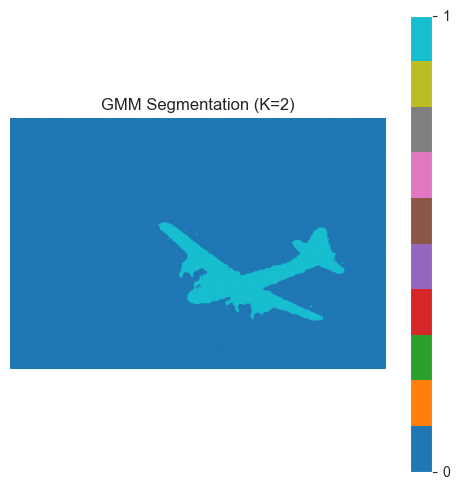

  Running K-Means with K=3...


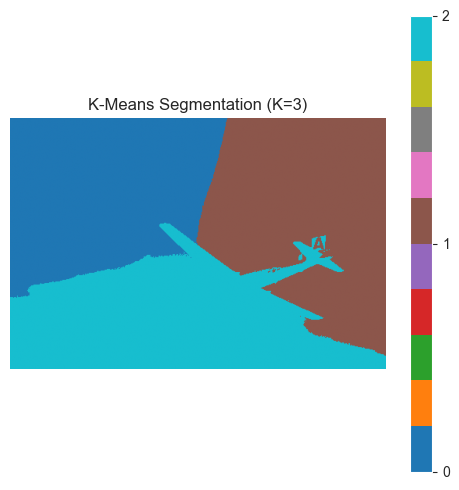

  Running GMM with K=3...


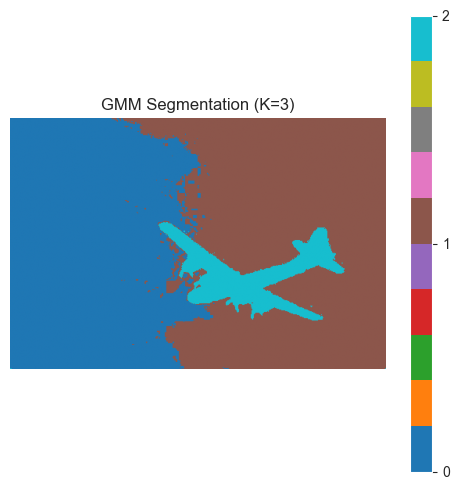

  Running K-Means with K=4...


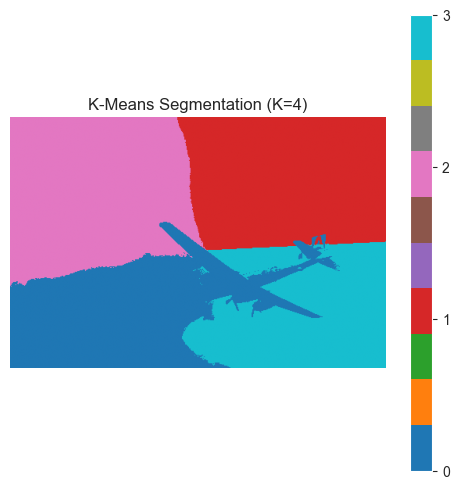

  Running GMM with K=4...


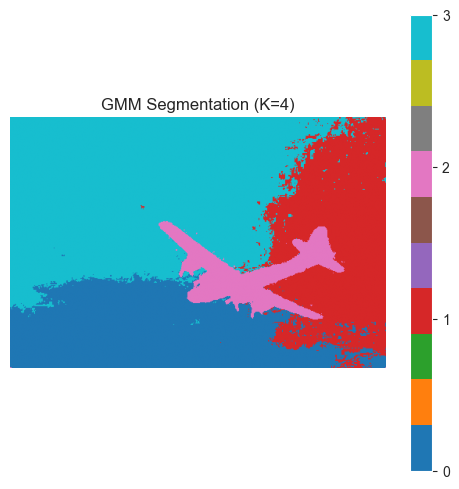

  Running K-Means with K=5...


  Running GMM with K=5...



Processing image: image2.jpg
  Running K-Means with K=2...


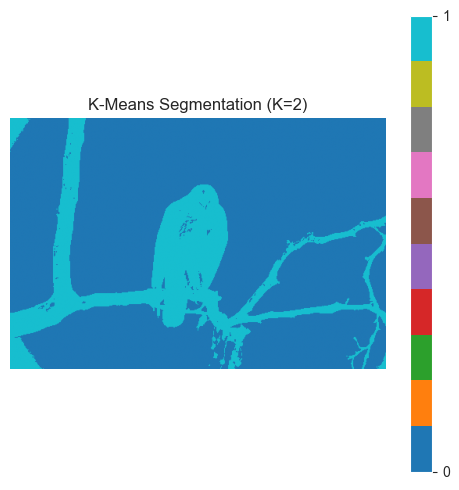

  Running GMM with K=2...


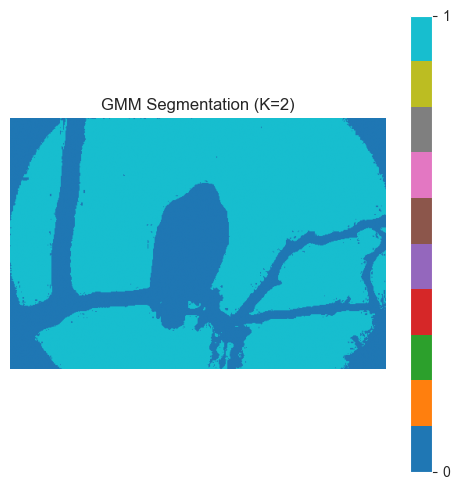

  Running K-Means with K=3...


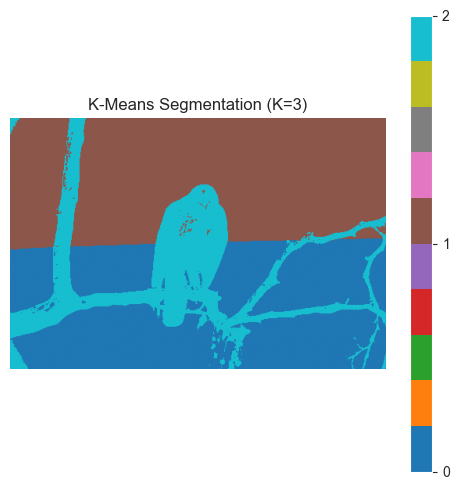

  Running GMM with K=3...


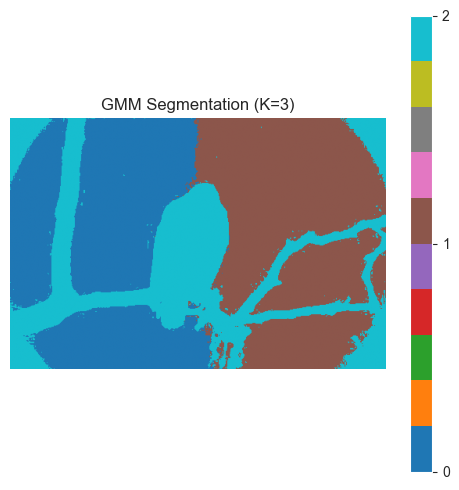

  Running K-Means with K=4...


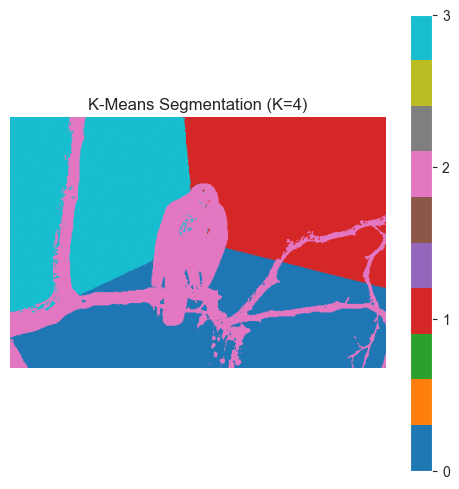

  Running GMM with K=4...


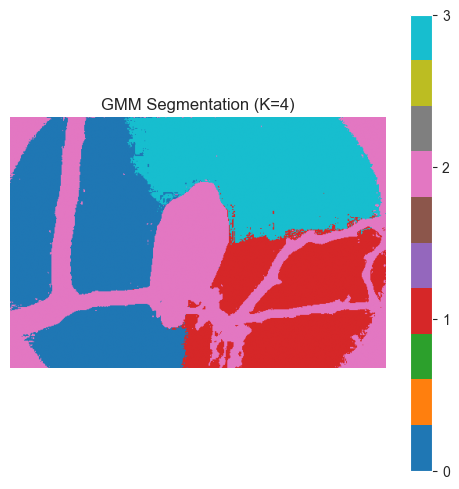

  Running K-Means with K=5...


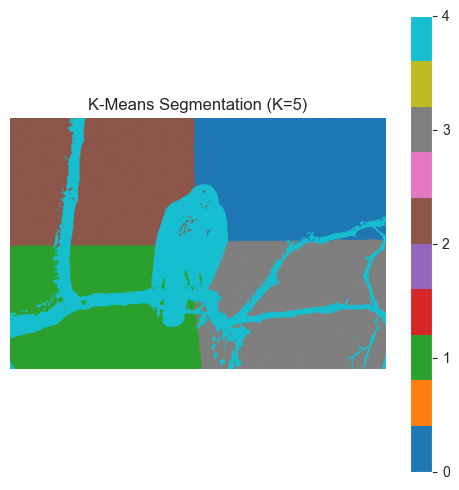

  Running GMM with K=5...


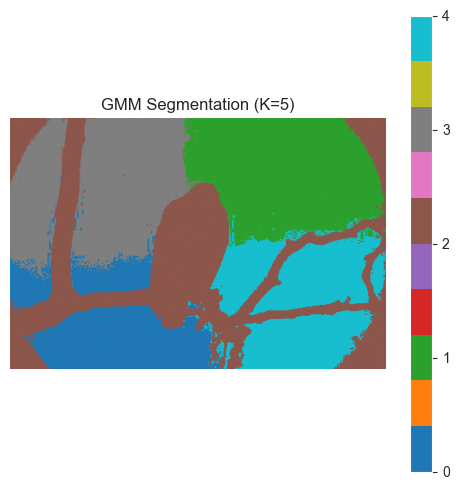

In [2]:
# question 9
# ignore the warnings
warnings.filterwarnings('ignore')
# building the 5d feature vecs
def build_features(img):
    """
    img: H x W x 3 image (float in [0,1])
    returns: (H*W) x 5 feature matrix
    """
    H, W, _ = img.shape

    # normalized coordinates
    ys = np.linspace(0, 1, H)
    xs = np.linspace(0, 1, W)
    Y, X = np.meshgrid(ys, xs, indexing="ij")
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]

    features = np.stack([Y, X, R, G, B], axis=-1)
    return features.reshape(-1, 5), H, W


# alternative image loading

def load_image_float(image_path):
    """
    Load image and convert to float [0,1]
    """
    try:
        from skimage import img_as_float
        img = img_as_float(io.imread(image_path))
    except (ImportError, AttributeError):
        # if fallback then -> manual conversion
        img = io.imread(image_path)
        # convert to float in [0, 1]
        if img.dtype == np.uint8:
            img = img.astype(np.float32) / 255.0
        elif img.dtype == np.uint16:
            img = img.astype(np.float32) / 65535.0
        elif img.dtype == np.float32 or img.dtype == np.float64:
            # ensure [0,1]
            img_max = img.max()
            if img_max > 1.0:
                img = img / img_max
        else:
            # covert to float and normalize
            img = img.astype(np.float32) / img.max()

    # 3 channels
    if len(img.shape) == 2:  # grayscale
        img = np.stack([img, img, img], axis=-1)
    elif img.shape[2] > 3:  # multi-channel
        img = img[:, :, :3]

    return img

# label image with distinct colors

def plot_labels(labels, H, W, K, title):
    label_img = labels.reshape(H, W)
    plt.figure(figsize=(5, 5))
    plt.imshow(label_img, cmap="tab10", vmin=0, vmax=K-1)
    plt.colorbar(ticks=range(K))
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# segmentation pipeline

def segment_image(image_path, Ks=(2, 3, 4, 5)):
    print(f"\nProcessing image: {image_path}")

    # load and convert
    img = load_image_float(image_path)
    # build features
    X, H, W = build_features(img)
    # k-means
    for K in Ks:
        print(f"  Running K-Means with K={K}...")
        kmeans = KMeans(n_clusters=K, n_init=10, random_state=0)
        labels_km = kmeans.fit_predict(X)
        plot_labels(
            labels_km, H, W, K,
            title=f"K-Means Segmentation (K={K})"
        )

        # gmm
        print(f"  Running GMM with K={K}...")
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            random_state=0
        )
        gmm.fit(X)
        labels_gmm = gmm.predict(X)  # MAP assignment

        plot_labels(
            labels_gmm, H, W, K,
            title=f"GMM Segmentation (K={K})"
        )

if __name__ == "__main__":
    image_paths = [
        "image1.jpg",
        "image2.jpg"
    ]

    import os
    for path in image_paths:
        if not os.path.exists(path):
            print(f"Warning: File '{path}' not found. Please check the path.")
            # create samples, so if they do not exist, we can go on
            if "image1.jpg" in path:
                print("Creating sample image1.jpg...")
                # sample image
                test_img = np.zeros((200, 300, 3), dtype=np.uint8)
                test_img[50:150, 100:200, :] = [255, 0, 0]  # red square
                test_img[50:150, 200:250, :] = [0, 255, 0]  # green rectangle
                from PIL import Image
                Image.fromarray(test_img).save("image1.jpg")

            if "image2.jpg" in path:
                print("Creating sample image2.jpg...")
                # Create another test image with circles
                from PIL import Image, ImageDraw
                img = Image.new('RGB', (300, 200), color='white')
                draw = ImageDraw.Draw(img)
                draw.ellipse((50, 50, 150, 150), fill='blue')
                draw.ellipse((180, 30, 280, 130), fill='yellow')
                img.save("image2.jpg")

    for path in image_paths:
        if os.path.exists(path):
            try:
                segment_image(path)
            except Exception as e:
                print(f"Error processing {path}: {e}")
        else:
            print(f"Skipping {path} - file not found")

<Figure size 1200x800 with 0 Axes>

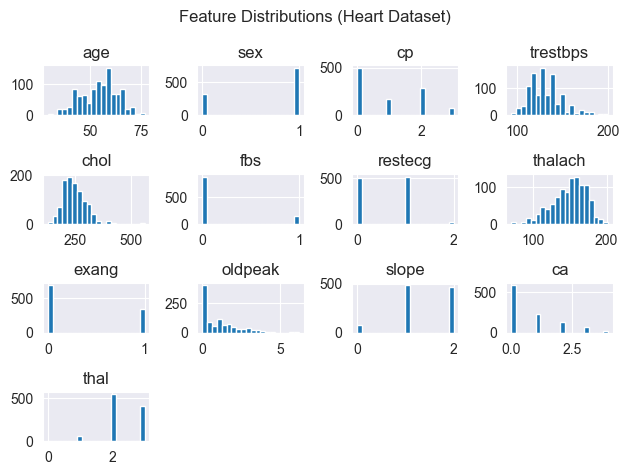

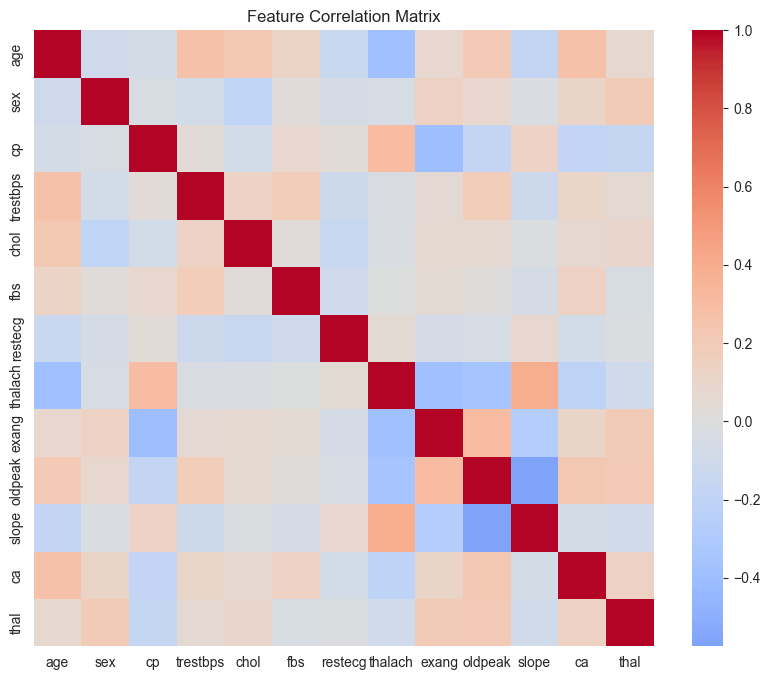

Highly correlated features removed: []

Baseline accuracy (all features): 0.8448780487804879

Mutual Information ranking:
chol        0.275314
thalach     0.147683
thal        0.136632
cp          0.135838
oldpeak     0.132645
ca          0.120577
exang       0.094500
trestbps    0.077058
age         0.051214
slope       0.050117
sex         0.033456
restecg     0.001491
fbs         0.000000
dtype: float64

Accuracy with top-5 MI features: 0.8146341463414635

RFE selected features: ['sex', 'cp', 'thalach', 'oldpeak', 'ca']
Accuracy with RFE features: 0.8087804878048781

RFECV selected features: ['sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Optimal number of features: 10
Accuracy with RFECV features: 0.8487804878048781

L1-selected features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Accuracy with L1 regularization: 0.8429268292682928


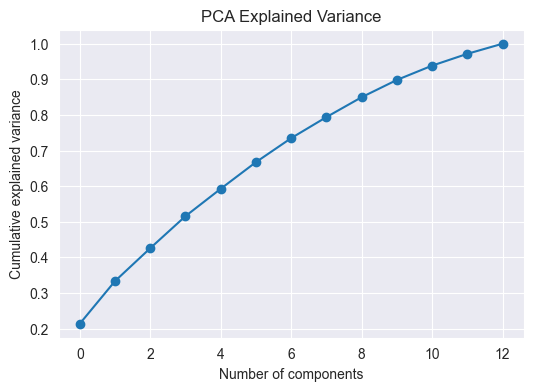


Components needed for 90% variance: 11


In [3]:
# question 8
df = pd.read_csv("heart.csv")

X = df.drop("target", axis=1)
y = df["target"]
feature_names = X.columns

# feature distributions
plt.figure(figsize=(12,8))
X.hist(bins=20)
plt.suptitle("Feature Distributions (Heart Dataset)")
plt.tight_layout()
plt.show()

# correlation matrix
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()
threshold = 0.85
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(abs(upper[c]) > threshold)]
print("Highly correlated features removed:", to_drop)

X_corr_filtered = X.drop(columns=to_drop)
# eval
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

# full feature
baseline_score = cross_val_score(
    clf, X_corr_filtered, y, cv=cv, scoring="accuracy"
).mean()

print("\nBaseline accuracy (all features):", baseline_score)

# universal selection
mi = mutual_info_classif(X_corr_filtered, y, random_state=42)
mi_scores = pd.Series(mi, index=X_corr_filtered.columns).sort_values(ascending=False)

print("\nMutual Information ranking:")
print(mi_scores)

k = 5
top_k_features = mi_scores.index[:k]
X_mi = X_corr_filtered[top_k_features]
mi_score = cross_val_score( clf, X_mi, y, cv=cv, scoring="accuracy" ).mean()

print(f"\nAccuracy with top-{k} MI features:", mi_score)

# RFE
estimator = LogisticRegression(max_iter=2000, solver="liblinear")
rfe = RFE(estimator, n_features_to_select=5)
rfe.fit(StandardScaler().fit_transform(X_corr_filtered), y)
rfe_features = X_corr_filtered.columns[rfe.support_]
print("\nRFE selected features:", list(rfe_features))
X_rfe = X_corr_filtered[rfe_features]
rfe_score = cross_val_score(clf, X_rfe, y, cv=cv, scoring="accuracy").mean()

print("Accuracy with RFE features:", rfe_score)

# RFECV
rfecv = RFECV( estimator, step=1, cv=cv, scoring="accuracy" )
rfecv.fit(StandardScaler().fit_transform(X_corr_filtered), y)

rfecv_features = X_corr_filtered.columns[rfecv.support_]
print("\nRFECV selected features:", list(rfecv_features))
print("Optimal number of features:", rfecv.n_features_)

X_rfecv = X_corr_filtered[rfecv_features]
rfecv_score = cross_val_score( clf, X_rfecv, y, cv=cv, scoring="accuracy" ).mean()

print("Accuracy with RFECV features:", rfecv_score)

# lg
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=2000
    ))
])

lasso.fit(X_corr_filtered, y)
coef = lasso.named_steps["clf"].coef_[0]
lasso_features = X_corr_filtered.columns[coef != 0]

print("\nL1-selected features:", list(lasso_features))

lasso_score = cross_val_score(
    lasso, X_corr_filtered, y, cv=cv, scoring="accuracy"
).mean()

print("Accuracy with L1 regularization:", lasso_score)

# pca
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr_filtered)

pca = PCA()
pca.fit(X_scaled)

explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(explained, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

print("\nComponents needed for 90% variance:",
      np.argmax(explained >= 0.9) + 1)


Iris PCA eigenvalues: [2.93808505 0.9201649 ]
Iris explained variance ratio: [0.72962445 0.22850762]
Cumulative explained variance: 0.9581320720000164


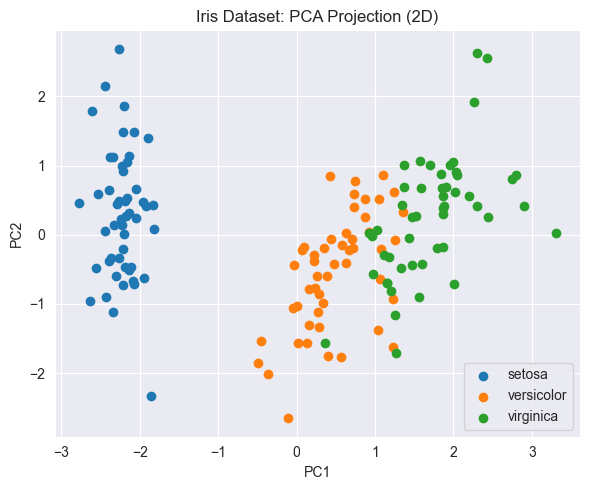


Circles PCA explained variance ratio: [0.50330035 0.49669965]


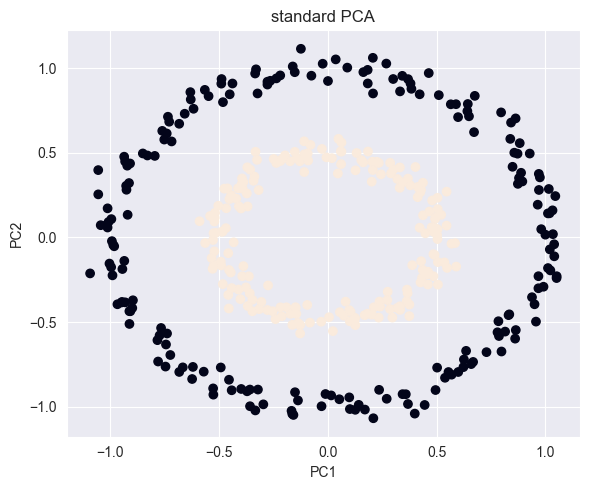

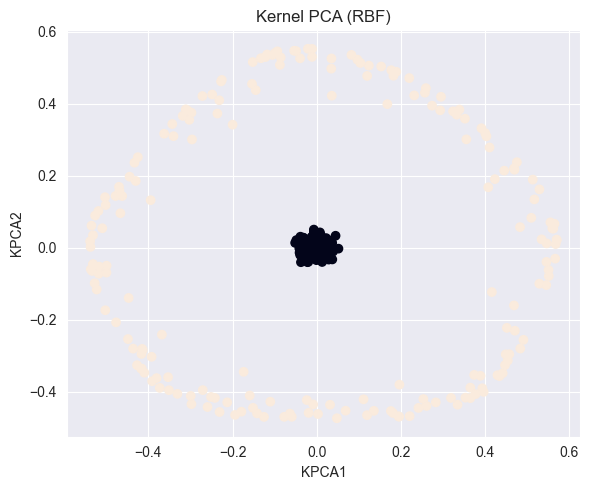

In [4]:
# question 7
# pca on iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

print("Iris PCA eigenvalues:", pca.explained_variance_)
print("Iris explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:",
      np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(6, 5))
for label in np.unique(y):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=target_names[label]
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Iris Dataset: PCA Projection (2D)")
plt.legend()
plt.tight_layout()
plt.show()

# pca and kernel pca
# generate a nonlinear dataset
X_circles, y_circles = make_circles( n_samples=400, factor=0.5, noise=0.05, random_state=0)
# noraml pca
pca_circles = PCA(n_components=2)
X_pca_circles = pca_circles.fit_transform(X_circles)

print("\nCircles PCA explained variance ratio:",
      pca_circles.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca_circles[:, 0],
    X_pca_circles[:, 1],
    c=y_circles
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("standard PCA")
plt.tight_layout()
plt.show()

# RBF kernel
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=15
)
X_kpca_circles = kpca.fit_transform(X_circles)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_kpca_circles[:, 0],
    X_kpca_circles[:, 1],
    c=y_circles
)
plt.xlabel("KPCA1")
plt.ylabel("KPCA2")
plt.title("Kernel PCA (RBF)")
plt.tight_layout()
plt.show()
